<a href="https://colab.research.google.com/github/YUMVOLKOVA/dul_2021/blob/main/hw3/Homework3_autoregressive_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

In [2]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


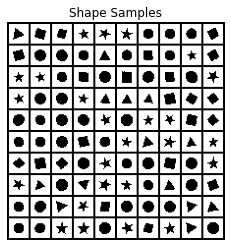

In [3]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

Часть кода взята из семинара 

In [4]:
import os
import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))

In [5]:
class MaskedConv(nn.Conv2d):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()

    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, bias=self.bias,
                        stride=self.stride, padding=self.padding)


class ConvA(MaskedConv):

    def set_mask(self):
        (h, w) = self.kernel_size
        self.mask[:, :, h // 2, :w // 2] = 1
        self.mask[:, :, :h // 2] = 1


class ConvB(MaskedConv):

    def set_mask(self):
        (h, w) = self.kernel_size
        self.mask[:, :, h // 2, :w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1

In [19]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels):
        super().__init__()
        self.in_ch = in_channels
        self.hd_ch = in_channels // 2
        self.activate_ = nn.ReLU()
        parameters = {'kernel_size': [1, 7]}
        seq = [ConvB(in_channels=self.in_ch, 
                     out_channels=self.hd_ch, 
                     kernel_size=parameters['kernel_size'][0]),
               self.activate_, 
               ConvB(in_channels=self.hd_ch, 
                     out_channels=self.hd_ch, 
                     kernel_size=parameters['kernel_size'][1], 
                     padding=parameters['kernel_size'][1] // 2),
               self.activate_,
               ConvB(in_channels=self.hd_ch, 
                     out_channels=self.in_ch, 
                     kernel_size=parameters['kernel_size'][0])]
        self.model_ = nn.Sequential(*seq)

    def forward(self, x):
        model = self.model_(x)
        output = model + x
        return output



In [51]:
from torch.distributions import Normal, Uniform
from tqdm.auto import tqdm
from torch.optim import Adam
from scipy import optimize

class FlowModel(nn.Module):
  def __init__(self, input_shape, hidden_filters, blocks, components):
    super().__init__()
    self.input_shape = input_shape
    self.height, self.width, self.channels = input_shape
    self.reorder_shape = self.channels, self.height, self.width
    self.hidden_filters = hidden_filters
    self.blocks = blocks
    self.components = components
    self.distribution = Uniform(torch.Tensor([0]).to(device), torch.Tensor([1]).to(device))
    self.activate_ = nn.ReLU()
    parameters = {'kernel_size': [1, 7]}

    seq = [ConvA(in_channels=self.input_shape[2],
                  out_channels=self.hidden_filters,
                  kernel_size=parameters['kernel_size'][1], 
                  padding=parameters['kernel_size'][1] // 2)]
    for block in range(self.blocks):
      seq.append(self.activate_)
      seq.append(ResidualBlock(self.hidden_filters))
    seq_ = [self.activate_, 
            ConvB(in_channels=self.hidden_filters,
                  out_channels=self.hidden_filters,
                  kernel_size=parameters['kernel_size'][0]),
            self.activate_, 
            ConvB(in_channels=self.hidden_filters, 
                  out_channels=3 * self.channels * self.components, 
                  kernel_size=parameters['kernel_size'][0])]
    seq = seq + seq_
    self.model_ = nn.Sequential(*seq)

  def forward(self, data):
    x = self.model_(data)
    x_reshaped = x.view(data.shape[0], self.components * 3, *self.reorder_shape)
    return x_reshaped

  def flow(self, data):
    x = self.forward(data)
    w, mu, log_sigma = x.chunk(3, dim=1)
    w = F.softmax(w, dim=1)
    log_sigma = torch.exp(log_sigma)
    distribution = Normal(mu, log_sigma)

    data = data.unsqueeze(1).repeat(1, self.components, 1, 1, 1)
    z = (distribution.cdf(data) * w).sum(dim=1)
    e_distrib_log_prob = distribution.log_prob(data).exp()
    return z, (e_distrib_log_prob * w).sum(dim=1).log()

  def nll(self, data):
    z, det_log = self.flow(data)
    z = torch.clamp(z, min=0, max=1)
    log_prob = self.distribution.log_prob(z) + det_log
    return -log_prob.mean()

  def fit(self, train_data, test_data, num_epochs=20, lr=5e-3):
    optim = Adam(self.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    test_losses.append(self.test(test_data))

    '''average negative log-likelihood (nats / dim) '''
    for epoch in tqdm(range(num_epochs)):
      nats = 0
      dim = 0    
      n = 0 
    
      for batch in tqdm(train_data):
        noise = torch.rand(batch[0].shape).to(device)
        batch = batch[0].to(device).float()
        loss = self.nll((batch / 2.0) + noise)
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
        optim.step()

        nats += loss * batch.shape[0]
        n +=  batch.shape[0]

      train_losses.append(nats.item() / n)
      test_losses.append(self.test(test_data))

    return train_losses, test_losses 

  def test(self, test_data):
    self.eval()
    nats = 0
    n = 0
    with torch.no_grad():
        for batch in test_data:
            batch = batch[0].to(device).float()
            loss = self.nll(batch)
            nats += loss * batch.shape[0]
            n += batch.shape[0]
    return nats.item() / n

  def inverse(self, w, mu, log_sigma):    

    z = self.distribution.sample((w.shape[0],))
    output = []
    for i in range(w.shape[0]):
      distribution = Normal(mu[i], log_sigma[i].exp())
      def f(x):
        x = torch.FloatTensor(np.repeat(x, self.components))
        x = x.to(device)
        dot = w[i] @ distribution.cdf(x)
        return dot - z[i]
      root = optimize.bisect(f, -20, 20)
      output.append(root)
    output = torch.FloatTensor(output)
    output = output.to(device)
    return output

  def sample(self):
    with torch.no_grad():
      x = torch.full((100, *self.reorder_shape), 0.0).to(device)

      for i in range(self.height):
        for j in range(self.width):
          for c in range(self.channels):
            chunk_x = self(x)[:, :, c, i, j]
            w, mu, log_sigma = chunk_x.chunk(3, dim=1)
            w = F.softmax(w, dim=1)
            x[:, c, i, j] = self.inverse(w, mu, log_sigma)

    x_cut = torch.clamp(x, min=0, max=1)
    x = x_cut.transpose(0, 2, 3, 1)
    return x.cpu().numpy()


In [48]:
params = {'hidden_filters': 120,
          'blocks': 8,
          'components': 8,
          'epochs': 20,
          'lr': 5e-3,
          'batch_size': 128}

In [52]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  input_shape = train_data.shape[1:]
  model = FlowModel(input_shape=input_shape, 
                    hidden_filters=params['hidden_filters'],
                    blocks=params['blocks'],
                    components=params['components'])
  model.to(device)
  train_data = torch.FloatTensor(train_data.transpose(0, 3, 1, 2))
  test_data = torch.FloatTensor(test_data.transpose(0, 3, 1, 2))
  train = DataLoader(torch.utils.data.TensorDataset(train_data), batch_size=params['batch_size'], shuffle=True)
  test = DataLoader(torch.utils.data.TensorDataset(test_data), batch_size=params['batch_size'], shuffle=False)
  train_losses, test_losses = model.fit(train, test, params['epochs'], params['lr'])
  print(f'train_losses: {train_losses}')
  print(f'test_losses: {test_losses}')


  return train_losses, test_losses, model.sample()


### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



In [53]:
q1_save_results(q1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

train_losses: [0.44121562507455386, 0.159949118381853, 0.13601779218779822, 0.12092638821169124, 0.12051862514090682, 0.12316393622438329, 0.10976103760720847, 0.0989637268398404, 0.09504889732031026, 0.09139374824798406, 0.10027264816090514, 0.08411705758988215, 0.09509722337159437, 0.08312257303856224, 0.07857148448683081, 0.0739045462110978, 0.07724713983398344, 0.07368677319296331, 0.07635524839671903, 0.07069198502100928]
test_losses: [1.3502448690784346, 0.4389346183686818, 0.6904035936456245, 0.5352505684111278, 0.5902314068240648, 0.4775549362614117, 0.6774576170570308, 0.5464722848474727, 0.4490009750403585, 0.6710126524750891, 0.6716937564364841, 0.3276405784659597, 0.6127786714922902, 0.7120069131318192, 0.5058527971742095, 0.4296976929118654, 0.4167725370445753, 0.3170593574301381, 0.46382375210490423, 0.48181329020889, 0.6304771543955967]


TypeError: ignored